# 使用SourceModule函数编写GPU内核函数计算多种指标

在本部分，我们将使用SourceModule函数编写不同的GPU内核函数，用于计算不同的指标，包括NDVI、SAVI、VARI、MNDWI和NDMI等。

In [1]:
import pycuda
import pycuda.driver as cuda
import pycuda.autoinit
import numpy as np
import time 
from pycuda.compiler import SourceModule
from PIL import Image
import tifffile as tiff
import matplotlib.pyplot as plt

## 1、计算NDVI

In [2]:
# 读取图像数据
def load_image(image_path):
    img = tiff.imread(image_path)[:,:,0]
    return img.astype(np.float32)

# 计算NDVI的CUDA内核代码
kernel_code_NDVI = """
__global__ void calculate_ndvi(float *nir, float *red, float *ndvi, int width, int height) {

    // 计算线程在图像中的位置
    int x = blockIdx.x * blockDim.x + threadIdx.x;
    int y = blockIdx.y * blockDim.y + threadIdx.y;

    // 判断是否越界
    if (x < width && y < height) {
        int idx = y * width + x;

        float nir_val = nir[idx];
        float red_val = red[idx];

        // 计算 NDVI
        if (nir_val + red_val != 0) {
            ndvi[idx] = (nir_val - red_val) / (nir_val + red_val);
        } else {
            ndvi[idx] = 0.0f;
        }
    }
}
"""

# 使用GPU加速NDVI计算
def ComputeNDVI_GPU(nir_image_path, red_image_path, output_image_path):

    # 记录开始时间
    start_time = time.time()
    
    # 加载图像
    nir_image = load_image(nir_image_path)
    red_image = load_image(red_image_path)
    
    # 记录计算开始时间
    start_time1 = time.time()
    
    # 获取图像的宽度和高度
    height, width = nir_image.shape

    # 创建一个空的 NDVI 图像
    ndvi_image = np.zeros_like(nir_image)

    # 将数据传输到 GPU
    nir_gpu = cuda.mem_alloc(nir_image.nbytes)
    red_gpu = cuda.mem_alloc(red_image.nbytes)
    ndvi_gpu = cuda.mem_alloc(ndvi_image.nbytes)

    cuda.memcpy_htod(nir_gpu, nir_image)
    cuda.memcpy_htod(red_gpu, red_image)

    # 编译 CUDA 内核
    mod = SourceModule(kernel_code_NDVI)
    calculate_ndvi = mod.get_function("calculate_ndvi")

    # 线程块大小 (32x32)
    block_size = (32, 32, 1)
    
    # 网格大小，基于图像的宽度和高度
    grid_size = (int(np.ceil(width / block_size[0])), int(np.ceil(height / block_size[1])), 1)

    # 启动内核函数
    calculate_ndvi(nir_gpu, red_gpu, ndvi_gpu, np.int32(width), np.int32(height), block=block_size, grid=grid_size)

    # 从 GPU 复制 NDVI 图像到主机
    cuda.memcpy_dtoh(ndvi_image, ndvi_gpu)

    # 将 NDVI 图像保存为输出文件
    ndvi_image = np.clip(ndvi_image, -1, 1)  # 保证值在合法范围内
    ndvi_image = ((ndvi_image + 1) / 2 * 255).astype(np.uint8)  # 将值缩放到 0-255
    ndvi_image_pil = Image.fromarray(ndvi_image)
    ndvi_image_pil.save(output_image_path)

    # 记录结束时间并计算总耗时
    end_time = time.time()
    elapsed_time = end_time - start_time
    computing_time = end_time - start_time1
    print(f"NDVI计算完成，输出图像已保存。总运行时间：{elapsed_time:.4f}秒, GPU计算时间：{computing_time:.4f}秒。")
    
# 使用CPU进行NDVI计算
def ComputeNDVI_CPU(nir_image_path, red_image_path, output_image_path):
    
    # 记录开始时间
    start_time = time.time()

    # 加载图像
    nir_image = load_image(nir_image_path)
    red_image = load_image(red_image_path)
    
    # 记录计算时间
    start_time1 = time.time()
    
    # 获取图像的高度和宽度
    height, width = nir_image.shape
    
    # 创建一个空的 NDVI 图像
    ndvi_image = np.zeros_like(nir_image)

    # 逐像素计算 NDVI
    for y in range(height):
        for x in range(width):
            nir_val = nir_image[y, x]
            red_val = red_image[y, x]
            
            if nir_val + red_val != 0:
                ndvi_image[y, x] = (nir_val - red_val) / (nir_val + red_val)
            else:
                ndvi_image[y, x] = 0.0
                
    # 将 NDVI 图像保存为输出文件
    ndvi_image = np.clip(ndvi_image, -1, 1)  # 保证值在合法范围内
    ndvi_image = ((ndvi_image + 1) / 2 * 255).astype(np.uint8)  # 将值缩放到 0-255
    ndvi_image_pil = Image.fromarray(ndvi_image)
    ndvi_image_pil.save(output_image_path)

    # 记录结束时间并计算总耗时
    end_time = time.time()
    elapsed_time = end_time - start_time
    computing_time = end_time - start_time1
    print(f"NDVI计算完成，输出图像已保存。总运行时间：{elapsed_time:.4f}秒, CPU计算时间：{computing_time:.4f}秒。")

使用GPU计算NDVI。

In [5]:
nir_image_path = "/mnt/SundarbansData/2020-01-27-00_00_2020-01-27-23_59_Sentinel-2_L2A_B08_(Raw).tiff"
red_image_path = "/mnt/SundarbansData/2020-01-27-00_00_2020-01-27-23_59_Sentinel-2_L2A_B04_(Raw).tiff"
output_image_path = "/mnt/output/NDVI_GPU.tiff"

ComputeNDVI_GPU(nir_image_path, red_image_path, output_image_path)

NDVI计算完成，输出图像已保存。总运行时间：0.0443秒, GPU计算时间：0.0157秒。


使用CPU计算NDVI。

In [16]:
output_image_path = "/mnt/output/NDVI_CPU.tiff"
ComputeNDVI_CPU(nir_image_path, red_image_path, output_image_path)

NDVI计算完成，输出图像已保存。总运行时间：0.7618秒, CPU计算时间：0.7317秒。


展示生成的NDVI图像

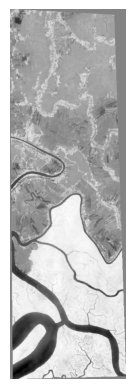

In [19]:
img_NDVI = tiff.imread("/mnt/output/NDVI_GPU.tiff")

# 显示图像
plt.imshow(img_NDVI, cmap='gray')
plt.axis('off')
plt.show()

## 2、计算SAVI

In [27]:
# 计算SAVI的CUDA内核代码
kernel_code_SAVI = """
__global__ void calculate_savi(float *nir, float *red, float *savi, int width, int height) {

    // 计算线程在图像中的位置
    int x = blockIdx.x * blockDim.x + threadIdx.x;
    int y = blockIdx.y * blockDim.y + threadIdx.y;

    // 判断是否越界
    if (x < width && y < height) {
        int idx = y * width + x;

        float nir_val = nir[idx];
        float red_val = red[idx];

        // 计算 SAVI
        savi[idx] = ((nir_val - red_val) / (nir_val + red_val + 0.5)) * 1.5;
        
    }
}
"""

# 使用GPU加速SAVI计算
def ComputeSAVI_GPU(nir_image_path, red_image_path, output_image_path):

    # 记录开始时间
    start_time = time.time()
    
    # 加载图像
    nir_image = load_image(nir_image_path)
    red_image = load_image(red_image_path)
    
    # 记录计算开始时间
    start_time1 = time.time()
    
    # 获取图像的宽度和高度
    height, width = nir_image.shape

    # 创建一个空的 SAVI 图像
    savi_image = np.zeros_like(nir_image)

    # 将数据传输到 GPU
    nir_gpu = cuda.mem_alloc(nir_image.nbytes)
    red_gpu = cuda.mem_alloc(red_image.nbytes)
    savi_gpu = cuda.mem_alloc(savi_image.nbytes)

    cuda.memcpy_htod(nir_gpu, nir_image)
    cuda.memcpy_htod(red_gpu, red_image)

    # 编译 CUDA 内核
    mod = SourceModule(kernel_code_SAVI)
    calculate_savi = mod.get_function("calculate_savi")

    # 线程块大小 (32x32)
    block_size = (32, 32, 1)
    
    # 网格大小，基于图像的宽度和高度
    grid_size = (int(np.ceil(width / block_size[0])), int(np.ceil(height / block_size[1])), 1)

    # 启动内核函数
    calculate_savi(nir_gpu, red_gpu, savi_gpu, np.int32(width), np.int32(height), block=block_size, grid=grid_size)

    # 从 GPU 复制 SAVI 图像到主机
    cuda.memcpy_dtoh(savi_image, savi_gpu)

    # 将 SAVI 图像保存为输出文件
    savi_image = np.clip(savi_image, -1, 1)  # 保证值在合法范围内
    savi_image = ((savi_image + 1) / 2 * 255).astype(np.uint8)  # 将值缩放到 0-255
    savi_image_pil = Image.fromarray(savi_image)
    savi_image_pil.save(output_image_path)

    # 记录结束时间并计算总耗时
    end_time = time.time()
    elapsed_time = end_time - start_time
    computing_time = end_time - start_time1
    print(f"SAVI计算完成，输出图像已保存。总运行时间：{elapsed_time:.4f}秒, GPU计算时间：{computing_time:.4f}秒。")
    
# 使用CPU进行NDVI计算
def ComputeSAVI_CPU(nir_image_path, red_image_path, output_image_path):
    
    # 记录开始时间
    start_time = time.time()

    # 加载图像
    nir_image = load_image(nir_image_path)
    red_image = load_image(red_image_path)
    
    # 记录计算时间
    start_time1 = time.time()
    
    # 获取图像的高度和宽度
    height, width = nir_image.shape
    
    # 创建一个空的 SAVI 图像
    savi_image = np.zeros_like(nir_image)

    # 逐像素计算 SAVI
    for y in range(height):
        for x in range(width):
            nir_val = nir_image[y, x]
            red_val = red_image[y, x]
            savi_image[y, x] = ((nir_val - red_val) / (nir_val + red_val + 0.5)) * 1.5
                
    # 将 SAVI 图像保存为输出文件
    savi_image = np.clip(savi_image, -1, 1)  # 保证值在合法范围内
    savi_image = ((savi_image + 1) / 2 * 255).astype(np.uint8)  # 将值缩放到 0-255
    savi_image_pil = Image.fromarray(savi_image)
    savi_image_pil.save(output_image_path)

    # 记录结束时间并计算总耗时
    end_time = time.time()
    elapsed_time = end_time - start_time
    computing_time = end_time - start_time1
    print(f"SAVI计算完成，输出图像已保存。总运行时间：{elapsed_time:.4f}秒, CPU计算时间：{computing_time:.4f}秒。")

使用GPU计算SAVI

In [28]:
nir_image_path = "/mnt/SundarbansData/2020-01-27-00_00_2020-01-27-23_59_Sentinel-2_L2A_B08_(Raw).tiff"
red_image_path = "/mnt/SundarbansData/2020-01-27-00_00_2020-01-27-23_59_Sentinel-2_L2A_B04_(Raw).tiff"
output_image_path = "/mnt/output/SAVI_GPU.tiff"

ComputeSAVI_GPU(nir_image_path, red_image_path, output_image_path)

SAVI计算完成，输出图像已保存。总运行时间：0.0399秒, GPU计算时间：0.0087秒。


使用CPU计算SAVI

In [32]:
output_image_path = "/mnt/output/SAVI_CPU.tiff"

ComputeSAVI_CPU(nir_image_path, red_image_path, output_image_path)

SAVI计算完成，输出图像已保存。总运行时间：1.4081秒, CPU计算时间：1.3804秒。


展示生成的SAVI图像

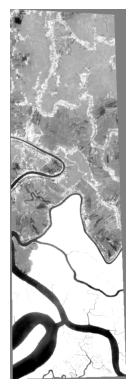

In [34]:
img_SAVI = tiff.imread("/mnt/output/SAVI_GPU.tiff")

# 显示图像
plt.imshow(img_SAVI, cmap='gray')
plt.axis('off')
plt.show()

## 3、计算VARI

In [49]:
# 计算VARI的CUDA内核代码
kernel_code_VARI = """
__global__ void calculate_vari(float *red, float *green, float *blue, float *vari, int width, int height) {

    // 计算线程在图像中的位置
    int x = blockIdx.x * blockDim.x + threadIdx.x;
    int y = blockIdx.y * blockDim.y + threadIdx.y;

    // 判断是否越界
    if (x < width && y < height) {
        int idx = y * width + x;

        float red_val = red[idx];
        float green_val = green[idx];
        float blue_val = blue[idx];

        // 计算 VARI
        if (green_val + red_val - blue_val != 0){
           vari[idx] = (green_val - red_val)/(green_val + red_val - blue_val);
        } else {
           vari[idx] = 0.0f;
        }
    }
}
"""

# 使用GPU加速VARI计算
def ComputeVARI_GPU(red_image_path, green_image_path, blue_image_path, output_image_path):

    # 记录开始时间
    start_time = time.time()
    
    # 加载图像
    red_image = load_image(red_image_path)
    green_image = load_image(green_image_path)
    blue_image = load_image(blue_image_path)
    
    # 记录计算开始时间
    start_time1 = time.time()
    
    # 获取图像的宽度和高度
    height, width = red_image.shape

    # 创建一个空的 VARI 图像
    vari_image = np.zeros_like(red_image)

    # 将数据传输到 GPU
    red_gpu = cuda.mem_alloc(red_image.nbytes)
    green_gpu = cuda.mem_alloc(green_image.nbytes)
    blue_gpu = cuda.mem_alloc(blue_image.nbytes)
    vari_gpu = cuda.mem_alloc(vari_image.nbytes)

    cuda.memcpy_htod(red_gpu, red_image)
    cuda.memcpy_htod(green_gpu, green_image)
    cuda.memcpy_htod(blue_gpu, blue_image)

    # 编译 CUDA 内核
    mod = SourceModule(kernel_code_VARI)
    calculate_vari = mod.get_function("calculate_vari")

    # 线程块大小 (32x32)
    block_size = (32, 32, 1)
    
    # 网格大小，基于图像的宽度和高度
    grid_size = (int(np.ceil(width / block_size[0])), int(np.ceil(height / block_size[1])), 1)

    # 启动内核函数
    calculate_vari(red_gpu, green_gpu, blue_gpu, vari_gpu, np.int32(width), np.int32(height), block=block_size, grid=grid_size)

    # 从 GPU 复制 VARI 图像到主机
    cuda.memcpy_dtoh(vari_image, vari_gpu)

    # 将 VARI 图像保存为输出文件
    vari_image = np.clip(vari_image, -1, 1)  # 保证值在合法范围内
    vari_image = ((vari_image + 1) / 2 * 255).astype(np.uint8)  # 将值缩放到 0-255
    vari_image_pil = Image.fromarray(vari_image)
    vari_image_pil.save(output_image_path)

    # 记录结束时间并计算总耗时
    end_time = time.time()
    elapsed_time = end_time - start_time
    computing_time = end_time - start_time1
    print(f"VARI计算完成，输出图像已保存。总运行时间：{elapsed_time:.4f}秒, GPU计算时间：{computing_time:.4f}秒。")
    
# 使用CPU进行VARI计算
def ComputeVARI_CPU(red_image_path, green_image_path, blue_image_path, output_image_path):
    
    # 记录开始时间
    start_time = time.time()

    # 加载图像
    red_image = load_image(red_image_path)
    green_image = load_image(green_image_path)
    blue_image = load_image(blue_image_path)
    
    # 记录计算时间
    start_time1 = time.time()
    
    # 获取图像的高度和宽度
    height, width = red_image.shape
    
    # 创建一个空的 VARI 图像
    vari_image = np.zeros_like(red_image)

    # 逐像素计算 VARI
    for y in range(height):
        for x in range(width):
            red_val = red_image[y, x]
            green_val = green_image[y, x]
            blue_val = blue_image[y, x]
            
            if green_val + red_val - blue_val != 0:
                vari_image[y, x] = (green_val - red_val)/(green_val + red_val - blue_val)
            else:
                vari_image[y, x] = 0
                
    # 将 VARI 图像保存为输出文件
    vari_image = np.clip(vari_image, -1, 1)  # 保证值在合法范围内
    vari_image = ((vari_image + 1) / 2 * 255).astype(np.uint8)  # 将值缩放到 0-255
    vari_image_pil = Image.fromarray(vari_image)
    vari_image_pil.save(output_image_path)

    # 记录结束时间并计算总耗时
    end_time = time.time()
    elapsed_time = end_time - start_time
    computing_time = end_time - start_time1
    print(f"VARI计算完成，输出图像已保存。总运行时间：{elapsed_time:.4f}秒, CPU计算时间：{computing_time:.4f}秒。")

使用GPU计算VARI

In [53]:
red_image_path = "/mnt/SundarbansData/2020-01-27-00_00_2020-01-27-23_59_Sentinel-2_L2A_B04_(Raw).tiff"
green_image_path = "/mnt/SundarbansData/2020-01-27-00_00_2020-01-27-23_59_Sentinel-2_L2A_B03_(Raw).tiff"
blue_image_path = "/mnt/SundarbansData/2020-01-27-00_00_2020-01-27-23_59_Sentinel-2_L2A_B02_(Raw).tiff"
output_image_path = "/mnt/output/VARI_GPU.tiff"

ComputeVARI_GPU(red_image_path, green_image_path, blue_image_path, output_image_path)

VARI计算完成，输出图像已保存。总运行时间：0.0658秒, GPU计算时间：0.0242秒。


使用CPU计算VARI

In [52]:
output_image_path = "/mnt/output/VARI_CPU.tiff"

ComputeVARI_CPU(red_image_path, green_image_path, blue_image_path, output_image_path)

VARI计算完成，输出图像已保存。总运行时间：0.8634秒, CPU计算时间：0.8259秒。


展示VARI图像

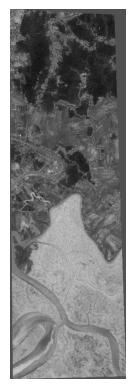

In [55]:
img_VARI = tiff.imread("/mnt/output/VARI_GPU.tiff")

# 显示图像
plt.imshow(img_VARI, cmap='gray')
plt.axis('off')
plt.show()

## 4、计算MNDWI

In [10]:
# 计算MNDWI的CUDA内核代码
kernel_code_MNDWI = """
__global__ void calculate_mndwi(float *green, float *swir, float *mndwi, int width, int height) {

    // 计算线程在图像中的位置
    int x = blockIdx.x * blockDim.x + threadIdx.x;
    int y = blockIdx.y * blockDim.y + threadIdx.y;

    // 判断是否越界
    if (x < width && y < height) {
        int idx = y * width + x;

        float green_val = green[idx];
        float swir_val = swir[idx];

        // 计算 MNDWI
        if (swir_val + green_val != 0){
           mndwi[idx] = (green_val - swir_val)/(green_val + swir_val);
        } else {
           mndwi[idx] = 0.0f;
        }
    }
}
"""

# 使用GPU加速MNDWI计算
def ComputeMNDWI_GPU(green_image_path, swir_image_path, output_image_path):

    # 记录开始时间
    start_time = time.time()
    
    # 加载图像
    green_image = load_image(green_image_path)
    swir_image = load_image(swir_image_path)
    
    # 记录计算开始时间
    start_time1 = time.time()
    
    # 获取图像的宽度和高度
    height, width = green_image.shape

    # 创建一个空的 MNDWI 图像
    mndwi_image = np.zeros_like(green_image)

    # 将数据传输到 GPU
    green_gpu = cuda.mem_alloc(green_image.nbytes)
    swir_gpu = cuda.mem_alloc(swir_image.nbytes)
    mndwi_gpu = cuda.mem_alloc(mndwi_image.nbytes)

    cuda.memcpy_htod(green_gpu, green_image)
    cuda.memcpy_htod(swir_gpu, swir_image)

    # 编译 CUDA 内核
    mod = SourceModule(kernel_code_MNDWI)
    calculate_mndwi = mod.get_function("calculate_mndwi")

    # 线程块大小 (32x32)
    block_size = (32, 32, 1)
    
    # 网格大小，基于图像的宽度和高度
    grid_size = (int(np.ceil(width / block_size[0])), int(np.ceil(height / block_size[1])), 1)

    # 启动内核函数
    calculate_mndwi(green_gpu, swir_gpu, mndwi_gpu, np.int32(width), np.int32(height), block=block_size, grid=grid_size)

    # 从 GPU 复制 MNDWI 图像到主机
    cuda.memcpy_dtoh(mndwi_image, mndwi_gpu)

    # 将 MNDWI 图像保存为输出文件
    mndwi_image = np.clip(mndwi_image, -1, 1)  # 保证值在合法范围内
    mndwi_image = ((mndwi_image + 1) / 2 * 255).astype(np.uint8)  # 将值缩放到 0-255
    mndwi_image_pil = Image.fromarray(mndwi_image)
    mndwi_image_pil.save(output_image_path)

    # 记录结束时间并计算总耗时
    end_time = time.time()
    elapsed_time = end_time - start_time
    computing_time = end_time - start_time1
    print(f"MNDWI计算完成，输出图像已保存。总运行时间：{elapsed_time:.4f}秒, GPU计算时间：{computing_time:.4f}秒。")
    
# 使用CPU进行MNDWI计算
def ComputeMNDWI_CPU(green_image_path, swir_image_path, output_image_path):
    
    # 记录开始时间
    start_time = time.time()

    # 加载图像
    green_image = load_image(green_image_path)
    swir_image = load_image(swir_image_path)
    
    # 记录计算时间
    start_time1 = time.time()
    
    # 获取图像的高度和宽度
    height, width = green_image.shape
    
    # 创建一个空的 MNDWI 图像
    mndwi_image = np.zeros_like(green_image)

    # 逐像素计算 MNDWI
    for y in range(height):
        for x in range(width):
            green_val = green_image[y, x]
            swir_val = swir_image[y, x]
            
            if green_val + swir_val != 0:
                mndwi_image[y, x] = (green_val - swir_val)/(green_val + swir_val)
            else:
                mndwi_image[y, x] = 0
                
    # 将MNDWI图像保存为输出文件
    mndwi_image = np.clip(mndwi_image, -1, 1)  # 保证值在合法范围内
    mndwi_image = ((mndwi_image + 1) / 2 * 255).astype(np.uint8)  # 将值缩放到 0-255
    mndwi_image_pil = Image.fromarray(mndwi_image)
    mndwi_image_pil.save(output_image_path)

    # 记录结束时间并计算总耗时
    end_time = time.time()
    elapsed_time = end_time - start_time
    computing_time = end_time - start_time1
    print(f"MNDWI计算完成，输出图像已保存。总运行时间：{elapsed_time:.4f}秒, CPU计算时间：{computing_time:.4f}秒。")

使用GPU计算MNDWI

In [17]:
green_image_path = "/mnt/SundarbansData/2020-01-27-00_00_2020-01-27-23_59_Sentinel-2_L2A_B03_(Raw).tiff"
swir_image_path = "/mnt/SundarbansData/2020-01-27-00_00_2020-01-27-23_59_Sentinel-2_L2A_B11_(Raw).tiff"
output_image_path = "/mnt/output/MNDWI_GPU.tiff"

ComputeMNDWI_GPU(green_image_path, swir_image_path, output_image_path)

MNDWI计算完成，输出图像已保存。总运行时间：0.0885秒, GPU计算时间：0.0142秒。


使用CPU计算MNDWI

In [18]:
output_image_path = "/mnt/output/MNDWI_CPU.tiff"

ComputeMNDWI_CPU(green_image_path, swir_image_path, output_image_path)

MNDWI计算完成，输出图像已保存。总运行时间：0.7636秒, CPU计算时间：0.7360秒。


展示MNDWI图像

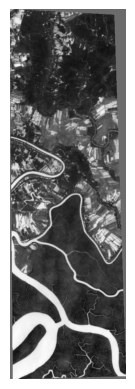

In [19]:
img_MNDWI = tiff.imread("/mnt/output/MNDWI_GPU.tiff")

# 显示图像
plt.imshow(img_MNDWI, cmap='gray')
plt.axis('off')
plt.show()

## 5、计算NDMI

In [22]:
# 计算NDMI的CUDA内核代码
kernel_code_NDMI = """
__global__ void calculate_ndmi(float *nir, float *swir, float *ndmi, int width, int height) {

    // 计算线程在图像中的位置
    int x = blockIdx.x * blockDim.x + threadIdx.x;
    int y = blockIdx.y * blockDim.y + threadIdx.y;

    // 判断是否越界
    if (x < width && y < height) {
        int idx = y * width + x;

        float nir_val = nir[idx];
        float swir_val = swir[idx];

        // 计算 NDMI
        if (swir_val + nir_val != 0){
           ndmi[idx] = (nir_val - swir_val)/(nir_val + swir_val);
        } else {
           ndmi[idx] = 0.0f;
        }
    }
}
"""

# 使用GPU加速NDMI计算
def ComputeNDMI_GPU(nir_image_path, swir_image_path, output_image_path):

    # 记录开始时间
    start_time = time.time()
    
    # 加载图像
    nir_image = load_image(nir_image_path)
    swir_image = load_image(swir_image_path)
    
    # 记录计算开始时间
    start_time1 = time.time()
    
    # 获取图像的宽度和高度
    height, width = nir_image.shape

    # 创建一个空的 NDMI 图像
    ndmi_image = np.zeros_like(nir_image)

    # 将数据传输到 GPU
    nir_gpu = cuda.mem_alloc(nir_image.nbytes)
    swir_gpu = cuda.mem_alloc(swir_image.nbytes)
    ndmi_gpu = cuda.mem_alloc(ndmi_image.nbytes)

    cuda.memcpy_htod(nir_gpu, nir_image)
    cuda.memcpy_htod(swir_gpu, swir_image)

    # 编译 CUDA 内核
    mod = SourceModule(kernel_code_NDMI)
    calculate_ndmi = mod.get_function("calculate_ndmi")

    # 线程块大小 (32x32)
    block_size = (32, 32, 1)
    
    # 网格大小，基于图像的宽度和高度
    grid_size = (int(np.ceil(width / block_size[0])), int(np.ceil(height / block_size[1])), 1)

    # 启动内核函数
    calculate_ndmi(nir_gpu, swir_gpu, ndmi_gpu, np.int32(width), np.int32(height), block=block_size, grid=grid_size)

    # 从 GPU 复制 NDMI 图像到主机
    cuda.memcpy_dtoh(ndmi_image, ndmi_gpu)

    # 将 NDMI 图像保存为输出文件
    ndmi_image = np.clip(ndmi_image, -1, 1)  # 保证值在合法范围内
    ndmi_image = ((ndmi_image + 1) / 2 * 255).astype(np.uint8)  # 将值缩放到 0-255
    ndmi_image_pil = Image.fromarray(ndmi_image)
    ndmi_image_pil.save(output_image_path)

    # 记录结束时间并计算总耗时
    end_time = time.time()
    elapsed_time = end_time - start_time
    computing_time = end_time - start_time1
    print(f"NDMI计算完成，输出图像已保存。总运行时间：{elapsed_time:.4f}秒, GPU计算时间：{computing_time:.4f}秒。")
    
# 使用CPU进行NDMI计算
def ComputeNDMI_CPU(nir_image_path, swir_image_path, output_image_path):
    
    # 记录开始时间
    start_time = time.time()

    # 加载图像
    nir_image = load_image(nir_image_path)
    swir_image = load_image(swir_image_path)
    
    # 记录计算时间
    start_time1 = time.time()
    
    # 获取图像的高度和宽度
    height, width = nir_image.shape
    
    # 创建一个空的 NDMI 图像
    ndmi_image = np.zeros_like(nir_image)

    # 逐像素计算 NDMI
    for y in range(height):
        for x in range(width):
            nir_val = nir_image[y, x]
            swir_val = swir_image[y, x]
            
            if nir_val + swir_val != 0:
                ndmi_image[y, x] = (nir_val - swir_val)/(nir_val + swir_val)
            else:
                ndmi_image[y, x] = 0
                
    # 将NDMI图像保存为输出文件
    ndmi_image = np.clip(ndmi_image, -1, 1)  # 保证值在合法范围内
    ndmi_image = ((ndmi_image + 1) / 2 * 255).astype(np.uint8)  # 将值缩放到 0-255
    ndmi_image_pil = Image.fromarray(ndmi_image)
    ndmi_image_pil.save(output_image_path)

    # 记录结束时间并计算总耗时
    end_time = time.time()
    elapsed_time = end_time - start_time
    computing_time = end_time - start_time1
    print(f"NDMI计算完成，输出图像已保存。总运行时间：{elapsed_time:.4f}秒, CPU计算时间：{computing_time:.4f}秒。")

使用GPU计算NDMI

In [24]:
nir_image_path = "/mnt/SundarbansData/2020-01-27-00_00_2020-01-27-23_59_Sentinel-2_L2A_B08_(Raw).tiff"
swir_image_path = "/mnt/SundarbansData/2020-01-27-00_00_2020-01-27-23_59_Sentinel-2_L2A_B11_(Raw).tiff"
output_image_path = "/mnt/output/NDMI_GPU.tiff"

ComputeNDMI_GPU(nir_image_path, swir_image_path, output_image_path)

NDMI计算完成，输出图像已保存。总运行时间：0.0320秒, GPU计算时间：0.0105秒。


使用CPU计算NDMI

In [26]:
output_image_path = "/mnt/output/NDMI_CPU.tiff"

ComputeNDMI_CPU(nir_image_path, swir_image_path, output_image_path)

NDMI计算完成，输出图像已保存。总运行时间：0.7563秒, CPU计算时间：0.7301秒。


展示NDMI图像

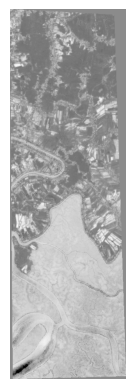

In [27]:
img_NDMI = tiff.imread("/mnt/output/NDMI_GPU.tiff")

# 显示图像
plt.imshow(img_NDMI, cmap='gray')
plt.axis('off')
plt.show()